In [1]:
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from eli5.sklearn import PermutationImportance
from catboost import CatBoostRegressor,Pool
import matplotlib.patches as patch
import matplotlib.pyplot as plt
from sklearn.svm import NuSVR
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import norm
from scipy import linalg
from sklearn import tree
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import graphviz
import warnings
import random
import eli5
import shap  # package used to calculate Shap values
import time
import glob
import sys
import os

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [2]:
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression

In [95]:
warnings.filterwarnings("ignore")

## 读入输入

In [25]:
# Reference: https://www.kaggle.com/mjbahmani/probability-of-earthquake-eda-fe-5-models/notebook
print("Reading csv files...")
train = pd.read_csv('./train.csv' , dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
print("Train: rows:{} columns:{}".format(train.shape[0], train.shape[1]))

rows = 150_000
segments = int(np.floor(train.shape[0] / rows)) # 4194

# X_train = pd.DataFrame(index=range(segments), dtype=np.float64) # 使用对应的特征
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])
submission = pd.read_csv('./sample_submission.csv', index_col='seg_id')
print("Reading ends.")

Reading csv files...
Train: rows:629145480 columns:2
Reading ends.


In [23]:
rows = 150_000
segments = 4194 # 4194
submission = pd.read_csv('./sample_submission.csv', index_col='seg_id')

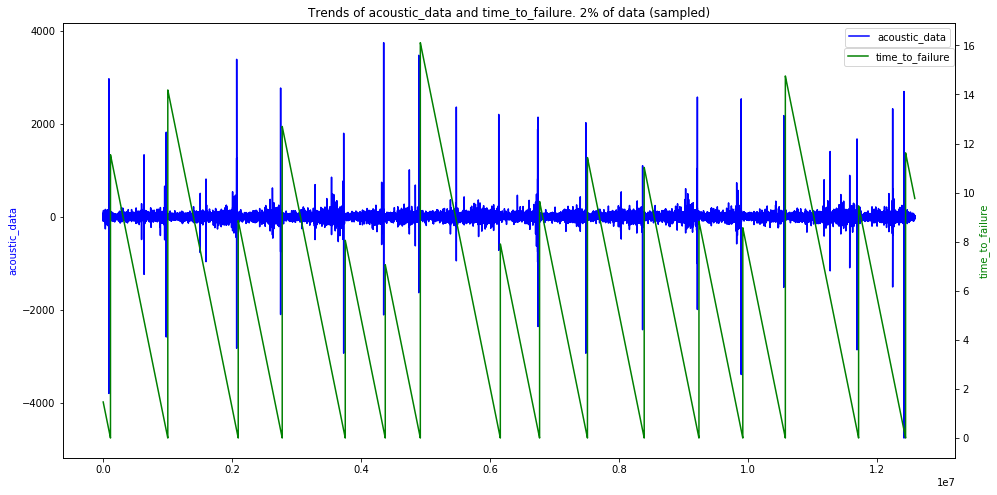

In [13]:
train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

## 特征工程

### 特征重要性排名: std, kurt, max, min, skew, ave, sum

In [9]:
#utils
def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]] # 因为会返回tuple，所以要加[0]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

# y = ax + b, solve a
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

In [5]:
# constant variable
total_mean = train['acoustic_data'].mean()
total_std = train['acoustic_data'].std()
total_max = train['acoustic_data'].max()
total_min = train['acoustic_data'].min()
total_sum = train['acoustic_data'].sum()
total_abs_sum = np.abs(train['acoustic_data']).sum()

- Usual aggregations: mean, std, min and max;
- Average difference between the consequitive values in absolute and percent values;
- Absolute min and max vallues;
- Aforementioned aggregations for first and last 10000 and 50000 values - I think these data should be useful;
- Max value to min value and their differencem also count of values bigger that 500 (arbitrary threshold);
- Quantile features from this kernel: https://www.kaggle.com/andrekos/basic-feature-benchmark-with-quantiles
- Trend features from this kernel: https://www.kaggle.com/jsaguiar/baseline-with-abs-and-trend-features
- Rolling features from this kernel: https://www.kaggle.com/wimwim/rolling-quantiles

In [138]:
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

In [139]:
print("Feature engineering...")
scale = 10 # test:使滑动窗口缩小10倍 
# X_train
# X_train = pd.DataFrame(index=range(segments*scale), dtype=np.float64) # 使用对应的特征
for segment in range(segments*scale):
    # y_train and X_train
#     if segment * rows / scale + rows > 4194:
#          break
    seg = train.iloc[int(segment * rows / scale): int(segment * rows / scale + rows)]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]  # 只取倒数第一个值，只过了0.0375s, 如果遇到阶跃怎么办？

    y_train.loc[segment, 'time_to_failure'] = y  # y_train
#     X_train.loc[segment, 'ave'] = x.mean()
#     X_train.loc[segment, 'std'] = x.std()
#     X_train.loc[segment, 'max'] = x.max()
#     X_train.loc[segment, 'min'] = x.min()
#     X_train.loc[segment, 'sum'] = x.sum()
#     X_train.loc[segment, 'skew'] = skew(x)
#     X_train.loc[segment, 'kurt'] = kurtosis(x)
#     X_train.loc[segment, 'mad'] = x.mad()
#     X_train.loc[segment, 'med'] = x.median()
    
#     X_train.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
#     X_train.loc[segment, 'mean_change_rate'] = calc_change_rate(x)
#     X_train.loc[segment, 'abs_max'] = np.abs(x).max()
#     X_train.loc[segment, 'abs_min'] = np.abs(x).min()
    
#     X_train.loc[segment, 'std_first_50000'] = x[:50000].std()
#     X_train.loc[segment, 'std_last_50000'] = x[-50000:].std()
#     X_train.loc[segment, 'std_first_10000'] = x[:10000].std()
#     X_train.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
#     X_train.loc[segment, 'avg_first_50000'] = x[:50000].mean()
#     X_train.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
#     X_train.loc[segment, 'avg_first_10000'] = x[:10000].mean()
#     X_train.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
#     X_train.loc[segment, 'min_first_50000'] = x[:50000].min()
#     X_train.loc[segment, 'min_last_50000'] = x[-50000:].min()
#     X_train.loc[segment, 'min_first_10000'] = x[:10000].min()
#     X_train.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
#     X_train.loc[segment, 'max_first_50000'] = x[:50000].max()
#     X_train.loc[segment, 'max_last_50000'] = x[-50000:].max()
#     X_train.loc[segment, 'max_first_10000'] = x[:10000].max()
#     X_train.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
#     X_train.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
#     X_train.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
#     X_train.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    
#     X_train.loc[segment, 'mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
#     X_train.loc[segment, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
#     X_train.loc[segment, 'mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
#     X_train.loc[segment, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
#     X_train.loc[segment, 'q95'] = np.quantile(x, 0.95)
#     X_train.loc[segment, 'q99'] = np.quantile(x, 0.99)
#     X_train.loc[segment, 'q05'] = np.quantile(x, 0.05)
#     X_train.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
#     X_train.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
#     X_train.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
#     X_train.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
#     X_train.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
#     X_train.loc[segment, 'trend'] = add_trend_feature(x)
#     X_train.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
#     X_train.loc[segment, 'abs_mean'] = np.abs(x).mean()
#     X_train.loc[segment, 'abs_std'] = np.abs(x).std()
    
#     # signal processing
#     X_train.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean() 
#     X_train.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean() 
#     X_train.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
#     X_train.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
#     X_train.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
#     X_train.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
#     X_train.loc[segment, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
#     X_train.loc[segment, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
#     X_train.loc[segment, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
#     X_train.loc[segment, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
#     X_train.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
#     ewma = pd.Series.ewm
#     X_train.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
#     X_train.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
#     X_train.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=30000).mean().mean(skipna=True)
#     no_of_std = 3
#     X_train.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
#     X_train.loc[segment,'MA_700MA_BB_high_mean'] = (X_train.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_train.loc[segment, 'MA_700MA_std_mean']).mean()
#     X_train.loc[segment,'MA_700MA_BB_low_mean'] = (X_train.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_train.loc[segment, 'MA_700MA_std_mean']).mean()
#     X_train.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
#     X_train.loc[segment,'MA_400MA_BB_high_mean'] = (X_train.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_train.loc[segment, 'MA_400MA_std_mean']).mean()
#     X_train.loc[segment,'MA_400MA_BB_low_mean'] = (X_train.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_train.loc[segment, 'MA_400MA_std_mean']).mean()
#     X_train.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
#     X_train.drop('Moving_average_700_mean', axis=1, inplace=True)
    
#     X_train.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
#     X_train.loc[segment, 'q999'] = np.quantile(x,0.999)
#     X_train.loc[segment, 'q001'] = np.quantile(x,0.001)
#     X_train.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)

#     for windows in [10, 100, 1000]:
#         x_roll_std = x.rolling(windows).std().dropna().values
#         x_roll_mean = x.rolling(windows).mean().dropna().values
        
#         X_train.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
#         X_train.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
#         X_train.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
#         X_train.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
#         X_train.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
#         X_train.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
#         X_train.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
#         X_train.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
#         X_train.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
#         X_train.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
#         X_train.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
#         X_train.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
#         X_train.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
#         X_train.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
#         X_train.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
#         X_train.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
#         X_train.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
#         X_train.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
#         X_train.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
#         X_train.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
#         X_train.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
#         X_train.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

Feature engineering...


In [196]:
# y_train test
for segment in range(segments * scale):
    seg = train.iloc[int(segment * rows / scale): int(segment * rows / scale + rows)]
    # x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]  # 只取倒数第一个值，只过了0.0375s, 如果遇到阶跃怎么办？

    y_train.loc[segment, 'time_to_failure'] = y  # y_train

In [108]:
# del X_test

In [158]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)
for seg_id in X_test.index:
    # X_test
    seg = pd.read_csv('./test/' + seg_id + '.csv')
    segment = seg_id 
    x = pd.Series(seg['acoustic_data'].values)
    
    X_test.loc[segment, 'ave'] = x.mean()
    X_test.loc[segment, 'std'] = x.std()
    X_test.loc[segment, 'max'] = x.max()
    X_test.loc[segment, 'min'] = x.min()
    X_test.loc[segment, 'sum'] = x.sum()
    X_test.loc[segment, 'skew'] = skew(x)
    X_test.loc[segment, 'kurt'] = kurtosis(x)
    X_test.loc[segment, 'mad'] = x.mad()
    X_test.loc[segment, 'med'] = x.median()
    
    X_test.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X_test.loc[segment, 'mean_change_rate'] = calc_change_rate(x)
    X_test.loc[segment, 'abs_max'] = np.abs(x).max()
    X_test.loc[segment, 'abs_min'] = np.abs(x).min()
    
    X_test.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_test.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_test.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_test.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X_test.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_test.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_test.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_test.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X_test.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_test.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_test.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_test.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X_test.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_test.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_test.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_test.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    X_test.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_test.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_test.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    
    X_test.loc[segment, 'mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
    X_test.loc[segment, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
    X_test.loc[segment, 'mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
    X_test.loc[segment, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
    X_test.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_test.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_test.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_test.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X_test.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_test.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_test.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_test.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_test.loc[segment, 'trend'] = add_trend_feature(x)
    X_test.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_test.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_test.loc[segment, 'abs_std'] = np.abs(x).std()
    
    # signal processing
    X_test.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean() 
    X_test.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean() 
    X_test.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_test.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_test.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_test.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_test.loc[segment, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
    X_test.loc[segment, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
    X_test.loc[segment, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
    X_test.loc[segment, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
    X_test.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_test.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_test.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_test.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=30000).mean().mean(skipna=True)
    no_of_std = 3
    X_test.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_test.loc[segment,'MA_700MA_BB_high_mean'] = (X_test.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_test.loc[segment, 'MA_700MA_std_mean']).mean()
    X_test.loc[segment,'MA_700MA_BB_low_mean'] = (X_test.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_test.loc[segment, 'MA_700MA_std_mean']).mean()
    X_test.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_test.loc[segment,'MA_400MA_BB_high_mean'] = (X_test.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_test.loc[segment, 'MA_400MA_std_mean']).mean()
    X_test.loc[segment,'MA_400MA_BB_low_mean'] = (X_test.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_test.loc[segment, 'MA_400MA_std_mean']).mean()
    X_test.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    X_test.drop('Moving_average_700_mean', axis=1, inplace=True)
    
    X_test.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_test.loc[segment, 'q999'] = np.quantile(x,0.999)
    X_test.loc[segment, 'q001'] = np.quantile(x,0.001)
    X_test.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)

    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_test.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_test.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_test.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_test.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_test.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_test.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_test.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_test.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_test.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_test.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_test.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_test.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_test.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_test.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [159]:
X_test.head(5)

,ave,std,max,min,sum,skew,kurt,mad,med,mean_change_abs,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
seg_id,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.491780,4.893690,115.0,-75.0,673767.0,0.327904,28.836567,3.248521,4.0,0.000027,...,0.231891,5.495,3.774,3.889,4.099,4.867,5.000,1.778523e-06,74583.596159,5.495
seg_0012b5,4.171153,5.922839,152.0,-140.0,625673.0,0.295705,56.217041,3.429208,4.0,-0.000013,...,0.230914,5.009,3.342,3.644,3.790,4.541,4.739,-1.946309e-07,74346.833285,5.009
seg_00184e,4.610260,6.946990,248.0,-193.0,691539.0,0.428684,162.112840,3.461984,5.0,-0.000020,...,0.247219,6.234,3.544,4.013,4.215,4.966,5.082,8.053691e-08,74349.464459,6.234
seg_003339,4.531473,4.114147,85.0,-93.0,679721.0,0.061889,41.240413,2.678503,5.0,0.000047,...,0.224909,5.446,3.889,4.032,4.184,4.911,5.051,3.899329e-06,74430.046483,5.446
seg_0042cc,4.128340,5.797164,177.0,-147.0,619251.0,0.073898,79.537016,3.283856,4.0,-0.000007,...,0.274025,5.027,3.357,3.534,3.662,4.570,4.870,-2.939597e-06,74545.727161,5.027


In [31]:
np.abs(X_train.corrwith(y_train['time_to_failure'])).sort_values(ascending=False).head(12)

q05_roll_std_100                0.648824
q01_roll_std_100                0.644797
q05_roll_std_10                 0.643123
q01_roll_std_10                 0.635264
q05_roll_std_1000               0.614482
q01_roll_std_1000               0.603691
min_roll_std_1000               0.544294
mean_change_rate                0.538691
mean_change_rate_last_50000     0.508633
mean_change_rate_first_50000    0.508158
iqr                             0.506994
classic_sta_lta6_mean           0.444735
dtype: float64

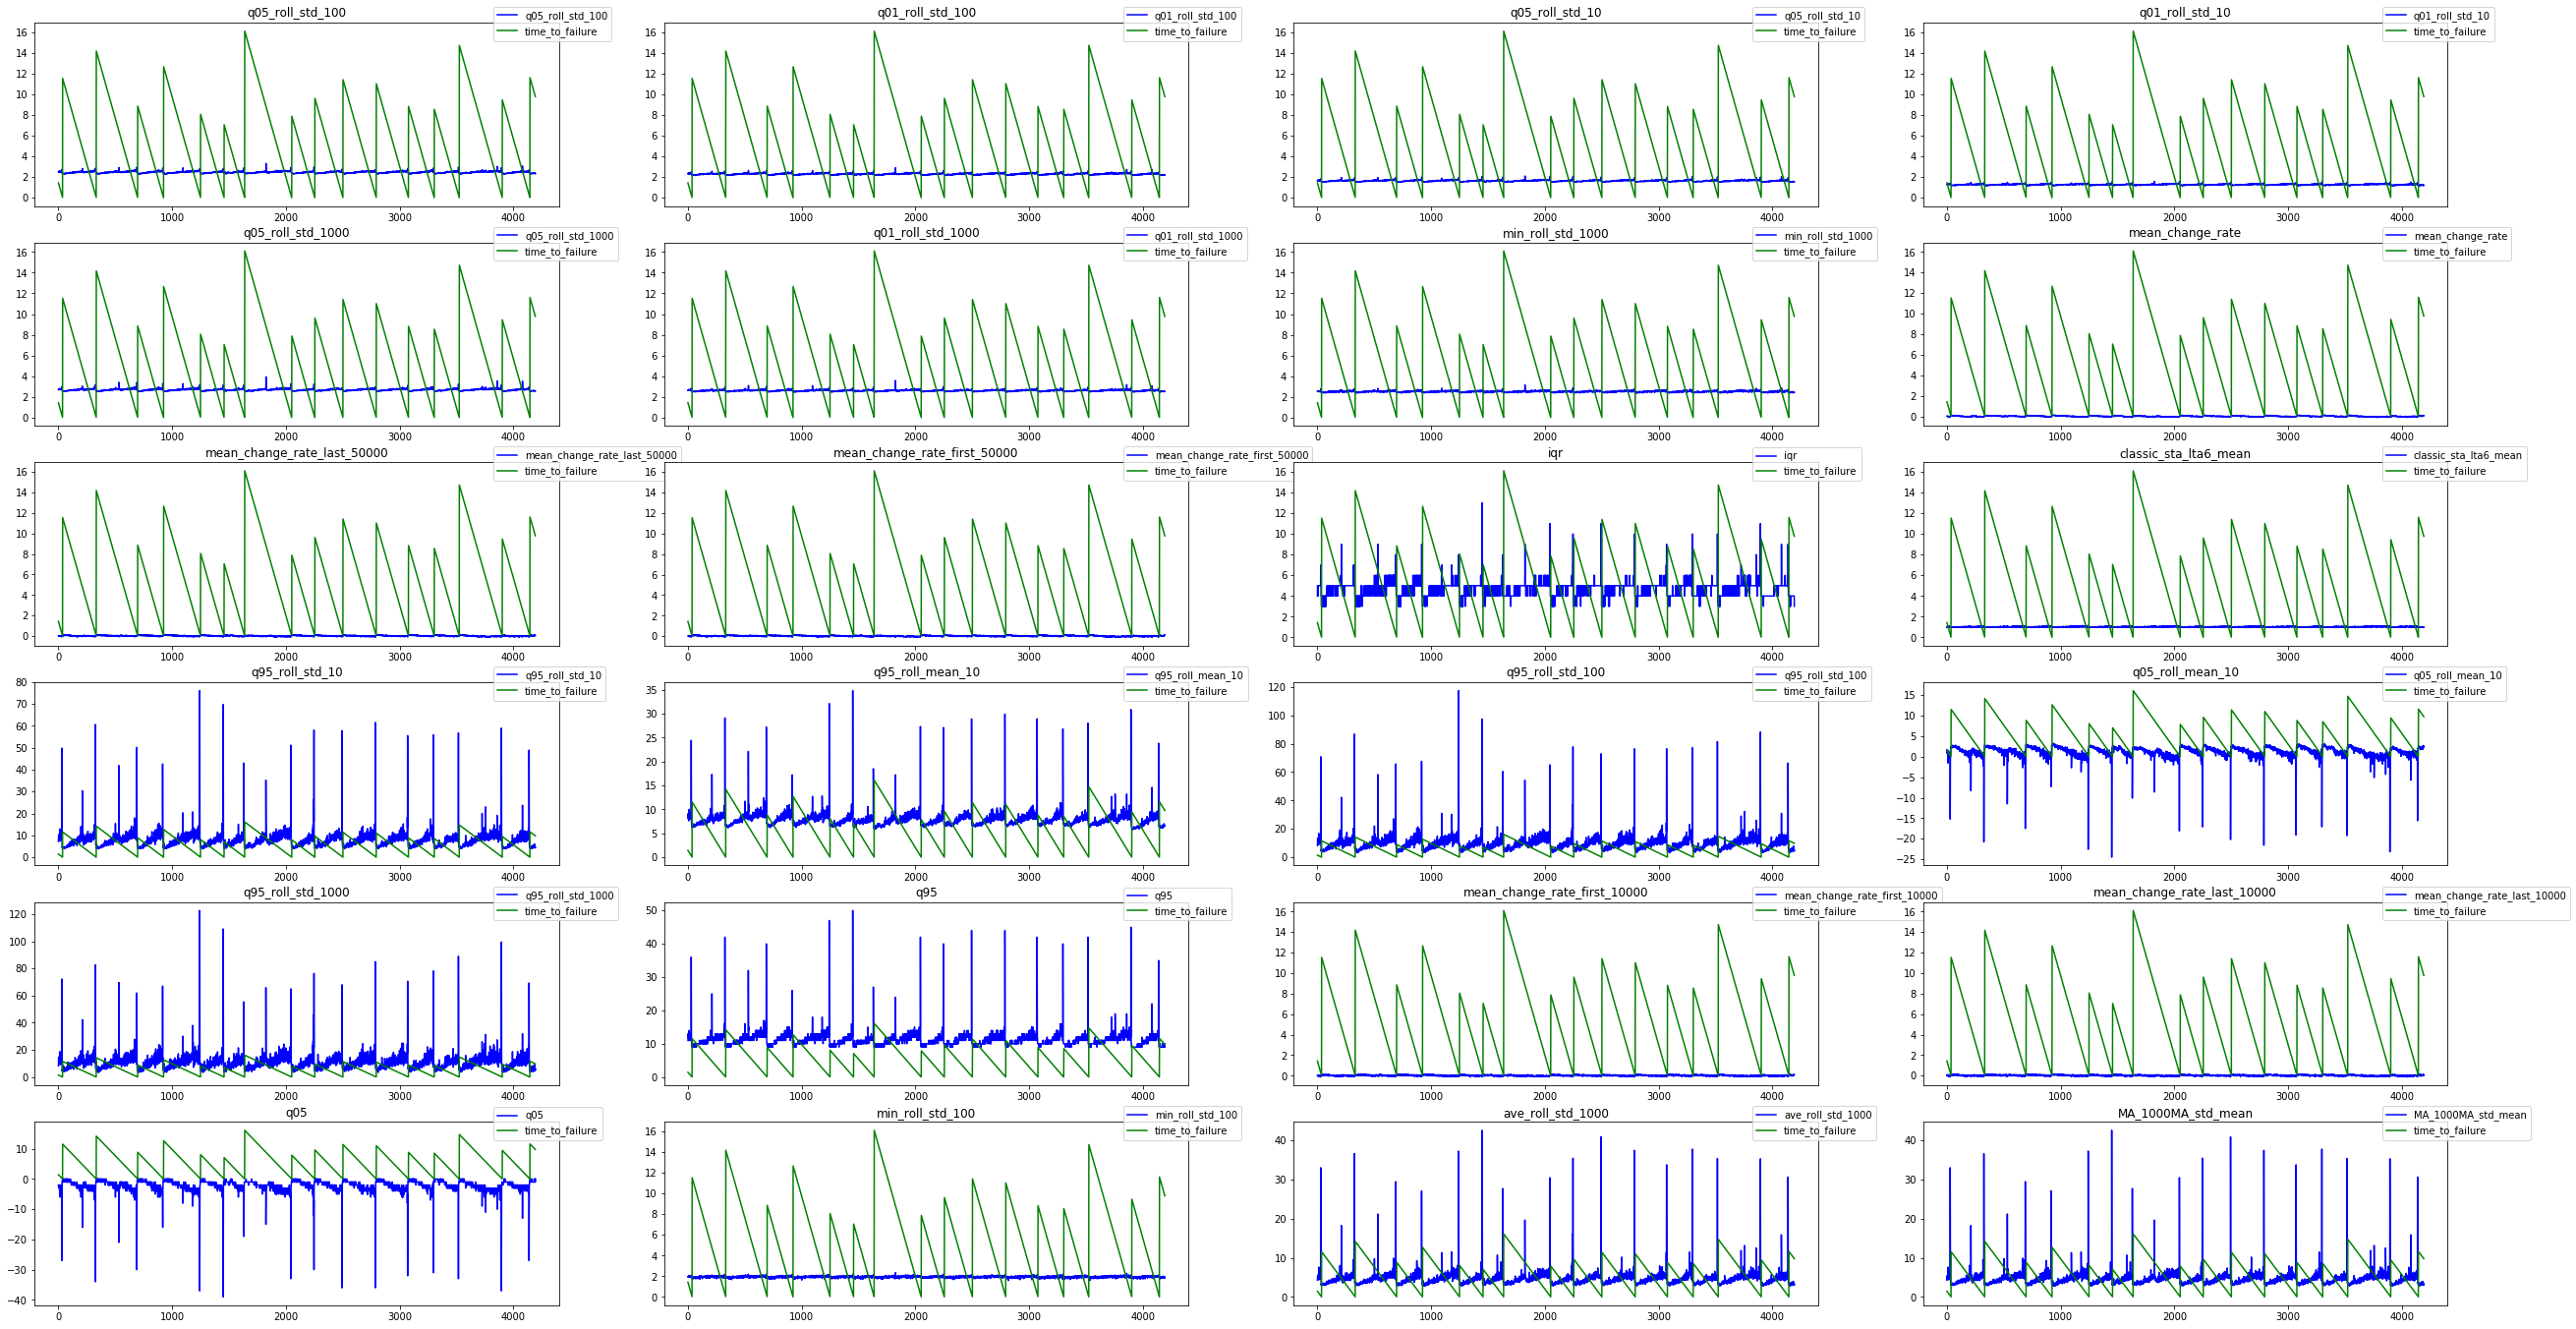

In [48]:
plt.figure(figsize=(44, 24))
cols = list(np.abs(X_train.corrwith(y_train['time_to_failure'])).sort_values(ascending=False).head(24).index)
for i, col in enumerate(cols):
    plt.subplot(6, 4, i + 1)
    plt.plot(X_train[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')

    ax2 = ax1.twinx()
    
    plt.plot(y_train, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend([col, 'time_to_failure'], loc=(0.875, 0.9))
    plt.grid(False)

In [164]:
means_dict = {}
for col in X_train.columns:
    if X_train[col].isnull().any():
        print(col)
        mean_value = X_train.loc[X_train[col] != -np.inf, col].mean()
        X_train.loc[X_train[col] == -np.inf, col] = mean_value
        X_train[col] = X_train[col].fillna(mean_value)
        means_dict[col] = mean_value

In [66]:
for col in X_test.columns:
    if X_test[col].isnull().any():
        X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
        X_test[col] = X_test[col].fillna(means_dict[col])

In [199]:
X = X_train.copy()
y = y_train.copy()
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [166]:
# 正则化X
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
print("Feature engineering ends.")

Feature engineering ends.


In [180]:
X_train.to_csv("X_train_41940samples_138features_filtered.csv")
X_test.to_csv("X_test_41940samples_138features_filtered.csv")

In [181]:
y_train.to_csv("y_train_41940sasmples.csv")

In [183]:
X_train = pd.read_csv("X_train_41940samples_138features_filtered.csv", index_col=0)

In [151]:
X_test = pd.read_csv("X_test_41940samples_138features_filtered.csv", index_col="seg_id")

In [184]:
y_train = pd.read_csv("y_train_41940sasmples.csv",index_col=0)

In [43]:
print(f'{X_train.shape[0]} samples in new train data and {X_train.shape[1]} columns.')

41940 samples in new train data and 138 columns.


In [155]:
X_train.head()

,ave,std,max,min,sum,skew,kurt,mad,med,mean_change_abs,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,4.884113,5.101106,104.0,-98.0,732617.0,-0.024061,33.661319,3.263401,5.0,-0.000080,...,0.295715,5.629,3.896,4.072,4.379,5.338,5.484,-0.000002,74222.343443,5.629
1,4.846000,5.357269,181.0,-154.0,726900.0,0.392545,107.655416,3.226245,5.0,0.000027,...,0.296046,5.667,3.412,4.069,4.368,5.320,5.483,-0.000004,74454.116773,5.667
2,4.811160,5.322245,181.0,-154.0,721674.0,0.413142,110.457754,3.208863,5.0,0.000033,...,0.303731,5.667,3.412,4.069,4.360,5.320,5.483,-0.000003,74346.540137,5.667
3,4.797067,5.429802,181.0,-154.0,719560.0,0.394846,102.280524,3.276233,5.0,0.000020,...,0.304487,5.667,3.412,4.069,4.359,5.320,5.483,0.000002,74689.738434,5.667
4,4.796347,6.236134,181.0,-154.0,719452.0,0.496783,112.567384,3.452447,5.0,0.000040,...,0.308286,5.667,3.412,4.069,4.359,5.320,5.483,-0.000001,74760.389481,5.667


In [192]:
y_train.head()

,time_to_failure
0,1.430797
1,1.426599
2,1.423396
3,1.419097
4,1.414899


In [193]:
X_test.head()

,ave,std,max,min,sum,skew,kurt,mad,med,mean_change_abs,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
seg_id,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.491780,4.893690,115.0,-75.0,673767.0,0.327904,28.836567,3.248521,4.0,0.000027,...,0.231891,5.495,3.774,3.889,4.099,4.867,5.000,1.778523e-06,74583.596159,5.495
seg_0012b5,4.171153,5.922839,152.0,-140.0,625673.0,0.295705,56.217041,3.429208,4.0,-0.000013,...,0.230914,5.009,3.342,3.644,3.790,4.541,4.739,-1.946309e-07,74346.833285,5.009
seg_00184e,4.610260,6.946990,248.0,-193.0,691539.0,0.428684,162.112840,3.461984,5.0,-0.000020,...,0.247219,6.234,3.544,4.013,4.215,4.966,5.082,8.053691e-08,74349.464459,6.234
seg_003339,4.531473,4.114147,85.0,-93.0,679721.0,0.061889,41.240413,2.678503,5.0,0.000047,...,0.224909,5.446,3.889,4.032,4.184,4.911,5.051,3.899329e-06,74430.046483,5.446
seg_0042cc,4.128340,5.797164,177.0,-147.0,619251.0,0.073898,79.537016,3.283856,4.0,-0.000007,...,0.274025,5.027,3.357,3.534,3.662,4.570,4.870,-2.939597e-06,74545.727161,5.027


In [159]:
print(f'{X_test_scaled.shape[0]} samples in new train data and {X_test_scaled.shape[1]} columns.')

2624 samples in new train data and 138 columns.


In [160]:
print(f'{y_train.shape[0]} samples in y_train data and {y_train.shape[1]} columns.')

41940 samples in y_train data and 1 columns.


In [161]:
X_train.shape

(41940, 138)

## 模型

### Building model utils

In [167]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [168]:
def train_model(X=X_train_scaled, X_test=X_test_scaled, y=y_train, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=3000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
            
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

### SVM

In [204]:
model = NuSVR(gamma='scale', nu=0.9, C=10.0, tol=0.01) # 对于大数据集， SVM一个fold要跑12min
oof_svr, prediction_svr = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

Fold 0 started at Wed Mar 27 20:12:20 2019
Fold 0. MAE: 1.9041.

Fold 1 started at Wed Mar 27 20:24:28 2019
Fold 1. MAE: 1.8962.

Fold 2 started at Wed Mar 27 20:36:07 2019
Fold 2. MAE: 1.8981.

Fold 3 started at Wed Mar 27 20:47:52 2019
Fold 3. MAE: 1.9139.

Fold 4 started at Wed Mar 27 20:59:56 2019
Fold 4. MAE: 1.8906.

CV mean score: 1.9006, std: 0.0079.


In [207]:
submission['time_to_failure'] = prediction_svr
submission.to_csv('submission_svr1_41940samples.csv')

In [89]:
prediction_svr = pd.read_csv('submission_svr1_41940samples.csv', index_col='seg_id')

In [169]:
model = NuSVR(gamma='scale', nu=0.7, tol=0.01, C=1.0)
oof_svr1, prediction_svr1 = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

Fold 0 started at Sat Mar 30 23:39:23 2019


D:\anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 0. MAE: 1.9738.

Fold 1 started at Sat Mar 30 23:44:53 2019


D:\anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 1. MAE: 1.9768.

Fold 2 started at Sat Mar 30 23:50:23 2019


D:\anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 2. MAE: 1.9721.

Fold 3 started at Sat Mar 30 23:55:49 2019


D:\anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 3. MAE: 1.9826.

Fold 4 started at Sun Mar 31 00:01:17 2019


D:\anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 4. MAE: 1.9613.

CV mean score: 1.9733, std: 0.0070.


In [186]:
submission['time_to_failure'] = prediction_svr1
submission.to_csv('submission_svr1_41940samples.csv')

In [75]:
print("SVM...")
svm = NuSVR()
svm.fit(X_train_scaled, y_train.values.flatten())
y_pred_svm = svm.predict(X_train_scaled)
score = mean_absolute_error(y_train.values.flatten(), y_pred_svm)
print(f'Score: {score:0.3f}')
y_pred_svm= svm.predict(X_test_scaled)
submission['time_to_failure'] = y_pred_svm
submission.to_csv('submission_svm_new.csv')
print("SVM ends.")

SVM...
Score: 2.183
SVM ends.


### lightGBM

Fold 0 started at Sun Mar 31 00:06:44 2019
Training until validation scores don't improve for 200 rounds.
[10000]	training's l1: 0.553698	valid_1's l1: 1.06849
[20000]	training's l1: 0.209905	valid_1's l1: 0.896615
[30000]	training's l1: 0.0862354	valid_1's l1: 0.850667
[40000]	training's l1: 0.0377043	valid_1's l1: 0.839626
[50000]	training's l1: 0.0175236	valid_1's l1: 0.837112
Did not meet early stopping. Best iteration is:
[50000]	training's l1: 0.0175236	valid_1's l1: 0.837112
Fold 1 started at Sun Mar 31 00:18:25 2019
Training until validation scores don't improve for 200 rounds.
[10000]	training's l1: 0.557193	valid_1's l1: 1.05812
[20000]	training's l1: 0.212445	valid_1's l1: 0.882273
[30000]	training's l1: 0.08655	valid_1's l1: 0.836253
[40000]	training's l1: 0.0378844	valid_1's l1: 0.824853
[50000]	training's l1: 0.0182891	valid_1's l1: 0.822409
Did not meet early stopping. Best iteration is:
[50000]	training's l1: 0.0182891	valid_1's l1: 0.822409
Fold 2 started at Sun Mar 31

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


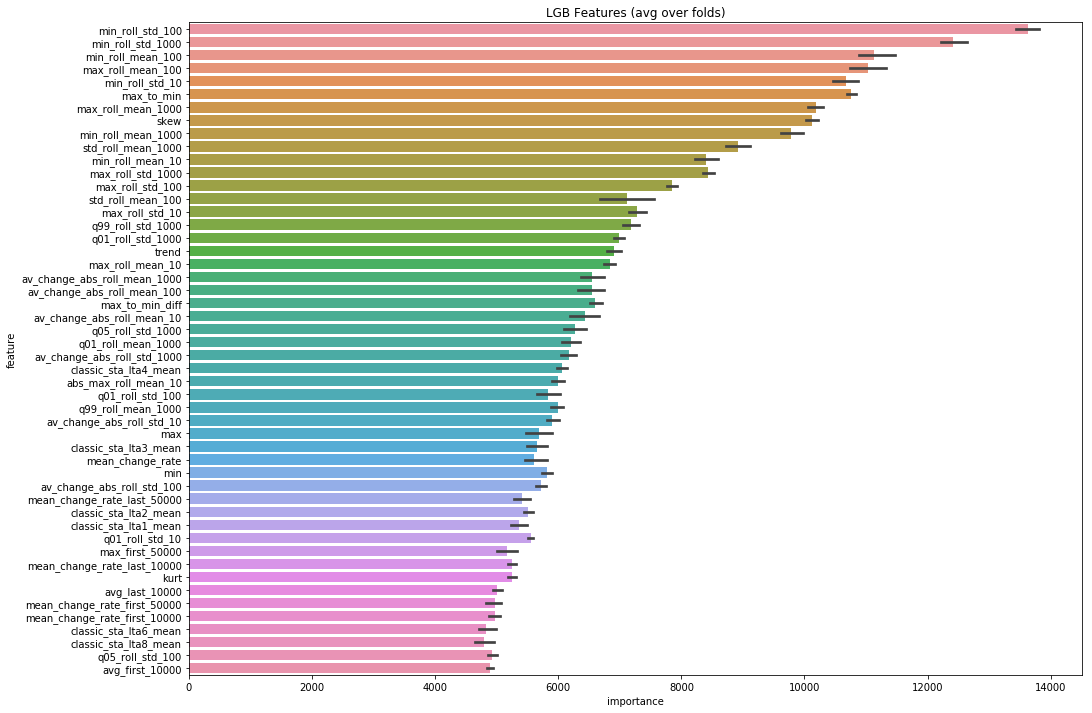

In [170]:
params = {'num_leaves': 54,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         } 
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', plot_feature_importance=True)

In [187]:
submission['time_to_failure'] = prediction_lgb
submission.to_csv('submission_lgb_41940samples.csv')

In [149]:
top_cols = list(feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index)

In [76]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)
params = {'objective' : "regression",
               'boosting':"gbdt",
               'metric':"mae",
               'boost_from_average':"false",
               'num_threads':8,
               'learning_rate' : 0.001,
               'num_leaves' : 52,
               'max_depth':-1,
               'tree_learner' : "serial",
               'feature_fraction' : 0.85,
               'bagging_freq' : 1,
               'bagging_fraction' : 0.85,
               'min_data_in_leaf' : 10,
               'min_sum_hessian_in_leaf' : 10.0,
               'verbosity' : -1}

y_pred_lgb = np.zeros(len(X_test_scaled))
for fold_n, (train_index, valid_index) in tqdm(enumerate(folds.split(X))):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    model = lgb.LGBMRegressor(**params, n_estimators=22000, n_jobs=-1)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
              verbose=1000, early_stopping_rounds=200)

    y_pred_valid = model.predict(X_valid)
    y_pred_lgb += model.predict(X_test_scaled, num_iteration=model.best_iteration_) / folds.n_splits
submission['time_to_failure'] = y_pred_lgb
submission.to_csv('submission_lgb.csv')
print("LightGBM ends.")


0it [00:00, ?it/s]

Fold 0 started at Tue Mar 26 15:48:48 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.71077	valid_1's l1: 2.69377
[2000]	training's l1: 2.08909	valid_1's l1: 2.09643
[3000]	training's l1: 1.98612	valid_1's l1: 2.01301
[4000]	training's l1: 1.93798	valid_1's l1: 1.9817
[5000]	training's l1: 1.89522	valid_1's l1: 1.95302
[6000]	training's l1: 1.85497	valid_1's l1: 1.92478
[7000]	training's l1: 1.8175	valid_1's l1: 1.89843
[8000]	training's l1: 1.78231	valid_1's l1: 1.87365
[9000]	training's l1: 1.74907	valid_1's l1: 1.85025
[10000]	training's l1: 1.71757	valid_1's l1: 1.82842
[11000]	training's l1: 1.68734	valid_1's l1: 1.80748
[12000]	training's l1: 1.65828	valid_1's l1: 1.7874
[13000]	training's l1: 1.63066	valid_1's l1: 1.76835
[14000]	training's l1: 1.60386	valid_1's l1: 1.74996
[15000]	training's l1: 1.57774	valid_1's l1: 1.73192
[16000]	training's l1: 1.55236	valid_1's l1: 1.71447
[17000]	training's l1: 1.52806	valid_1's l1: 1.69788
[1800

1it [00:42, 42.94s/it]

Fold 1 started at Tue Mar 26 15:49:31 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.70818	valid_1's l1: 2.72371
[2000]	training's l1: 2.08766	valid_1's l1: 2.11227
[3000]	training's l1: 1.98332	valid_1's l1: 2.02253
[4000]	training's l1: 1.93592	valid_1's l1: 1.98781
[5000]	training's l1: 1.89379	valid_1's l1: 1.95826
[6000]	training's l1: 1.85417	valid_1's l1: 1.93006
[7000]	training's l1: 1.81688	valid_1's l1: 1.90379
[8000]	training's l1: 1.78205	valid_1's l1: 1.87925
[9000]	training's l1: 1.74874	valid_1's l1: 1.8558
[10000]	training's l1: 1.71699	valid_1's l1: 1.83371
[11000]	training's l1: 1.68666	valid_1's l1: 1.81262
[12000]	training's l1: 1.65773	valid_1's l1: 1.79272
[13000]	training's l1: 1.6299	valid_1's l1: 1.77353
[14000]	training's l1: 1.60287	valid_1's l1: 1.75489
[15000]	training's l1: 1.57668	valid_1's l1: 1.73692
[16000]	training's l1: 1.55106	valid_1's l1: 1.71936
[17000]	training's l1: 1.52681	valid_1's l1: 1.70282
[180

2it [01:30, 44.18s/it]

Fold 2 started at Tue Mar 26 15:50:18 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.71003	valid_1's l1: 2.7051
[2000]	training's l1: 2.08568	valid_1's l1: 2.11581
[3000]	training's l1: 1.9814	valid_1's l1: 2.03292
[4000]	training's l1: 1.93372	valid_1's l1: 2.00078
[5000]	training's l1: 1.89202	valid_1's l1: 1.97241
[6000]	training's l1: 1.85282	valid_1's l1: 1.94539
[7000]	training's l1: 1.81544	valid_1's l1: 1.91936
[8000]	training's l1: 1.78085	valid_1's l1: 1.89537
[9000]	training's l1: 1.74796	valid_1's l1: 1.87243
[10000]	training's l1: 1.71628	valid_1's l1: 1.85066
[11000]	training's l1: 1.68627	valid_1's l1: 1.82999
[12000]	training's l1: 1.65746	valid_1's l1: 1.81009
[13000]	training's l1: 1.6297	valid_1's l1: 1.79095
[14000]	training's l1: 1.60296	valid_1's l1: 1.77282
[15000]	training's l1: 1.57665	valid_1's l1: 1.75469
[16000]	training's l1: 1.55153	valid_1's l1: 1.7374
[17000]	training's l1: 1.52729	valid_1's l1: 1.72094
[18000

3it [02:16, 44.90s/it]

Fold 3 started at Tue Mar 26 15:51:04 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.69383	valid_1's l1: 2.76343
[2000]	training's l1: 2.0698	valid_1's l1: 2.16884
[3000]	training's l1: 1.96738	valid_1's l1: 2.08269
[4000]	training's l1: 1.9204	valid_1's l1: 2.04912
[5000]	training's l1: 1.87893	valid_1's l1: 2.01873
[6000]	training's l1: 1.83998	valid_1's l1: 1.9897
[7000]	training's l1: 1.80321	valid_1's l1: 1.96257
[8000]	training's l1: 1.76895	valid_1's l1: 1.93736
[9000]	training's l1: 1.73587	valid_1's l1: 1.91284
[10000]	training's l1: 1.70498	valid_1's l1: 1.8903
[11000]	training's l1: 1.67518	valid_1's l1: 1.86858
[12000]	training's l1: 1.64658	valid_1's l1: 1.84758
[13000]	training's l1: 1.61895	valid_1's l1: 1.82759
[14000]	training's l1: 1.59237	valid_1's l1: 1.80822
[15000]	training's l1: 1.56669	valid_1's l1: 1.78949
[16000]	training's l1: 1.54152	valid_1's l1: 1.77119
[17000]	training's l1: 1.51726	valid_1's l1: 1.75361
[18000

4it [03:03, 45.52s/it]

Fold 4 started at Tue Mar 26 15:51:51 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.70453	valid_1's l1: 2.71839
[2000]	training's l1: 2.08421	valid_1's l1: 2.11917
[3000]	training's l1: 1.98194	valid_1's l1: 2.02937
[4000]	training's l1: 1.93437	valid_1's l1: 1.99226
[5000]	training's l1: 1.89263	valid_1's l1: 1.96135
[6000]	training's l1: 1.85338	valid_1's l1: 1.93271
[7000]	training's l1: 1.81608	valid_1's l1: 1.90596
[8000]	training's l1: 1.78108	valid_1's l1: 1.88119
[9000]	training's l1: 1.74808	valid_1's l1: 1.85808
[10000]	training's l1: 1.7164	valid_1's l1: 1.83602
[11000]	training's l1: 1.68603	valid_1's l1: 1.81515
[12000]	training's l1: 1.65648	valid_1's l1: 1.79472
[13000]	training's l1: 1.62843	valid_1's l1: 1.77573
[14000]	training's l1: 1.6012	valid_1's l1: 1.75709
[15000]	training's l1: 1.57479	valid_1's l1: 1.73904
[16000]	training's l1: 1.54919	valid_1's l1: 1.72161
[17000]	training's l1: 1.52432	valid_1's l1: 1.70463
[180

5it [03:50, 45.84s/it]


LightGBM ends.


In [77]:
y_pred_train_lgbm = model.predict(X)
score = mean_absolute_error(y.values.flatten(), y_pred_train_lgbm)
print(f'Score: {score:0.3f}')

Score: 1.456


### XGBoost

In [83]:
xgb_params = {'eta': 0.03,
              'max_depth': 10,
              'subsample': 0.9,
              'objective': 'reg:linear',
              'eval_metric': 'mae',
              'silent': True,
              'nthread': 4}
oof_xgb, prediction_xgb = train_model(X=X_train_scaled, X_test=X_test_scaled, params=xgb_params, model_type='xgb')

Fold 0 started at Sat Mar 30 16:56:28 2019
[0]	train-mae:5.06765	valid_data-mae:5.02463
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
[500]	train-mae:0.393294	valid_data-mae:1.05287
[1000]	train-mae:0.149312	valid_data-mae:0.938256
[1500]	train-mae:0.065209	valid_data-mae:0.90891
[2000]	train-mae:0.03066	valid_data-mae:0.899266
[2500]	train-mae:0.015429	valid_data-mae:0.896241
[3000]	train-mae:0.007861	valid_data-mae:0.895019
[3500]	train-mae:0.004094	valid_data-mae:0.894497
[4000]	train-mae:0.002154	valid_data-mae:0.894281
[4500]	train-mae:0.00115	valid_data-mae:0.894183
[5000]	train-mae:0.000635	valid_data-mae:0.894136
[5500]	train-mae:0.000466	valid_data-mae:0.894122
Stopping. Best iteration:
[5690]	train-mae:0.000451	valid_data-mae:0.89412

Fold 1 started at Sat Mar 30 17:15:36 2019
[0]	train-mae:5.05897	valid_data-mae:5.05837
Multiple eval metrics have been passed: 'valid_da

In [188]:
submission['time_to_failure'] = prediction_xgb
submission.to_csv('submission_xgb_41940samples.csv')

### CatBoost

In [171]:
params = {'loss_function':'MAE'}
oof_cat, prediction_cat = train_model(X=X_train_scaled, X_test=X_test_scaled, params=params, model_type='cat')

Fold 0 started at Sun Mar 31 01:05:17 2019
Fold 1 started at Sun Mar 31 01:10:30 2019
Fold 2 started at Sun Mar 31 01:15:44 2019
Fold 3 started at Sun Mar 31 01:20:59 2019
Fold 4 started at Sun Mar 31 01:26:14 2019
CV mean score: 1.8242, std: 0.0094.


In [189]:
submission['time_to_failure'] = prediction_cat
submission.to_csv('submission_cat_41940samples.csv')

In [15]:
print("CatBoost...")
train_pool = Pool(X,y)
cat_model = CatBoostRegressor(
                               iterations=3000,  # change 25 to 3000 to get best performance
                               learning_rate=0.03,
                               eval_metric='MAE',
                              )
cat_model.fit(X,y,silent=True)
y_pred_cat = cat_model.predict(X_test)
submission['time_to_failure'] = y_pred_cat
submission.to_csv('submission_cat.csv')
print("CatBoost ends.")



CatBoost...
CatBoost ends.


In [17]:
y_pred_train_cat = cat_model.predict(X)
score = mean_absolute_error(y.values.flatten(), y_pred_train_cat)
print(f'Score: {score:0.3f}')

Score: 1.932


### RandomForest

In [172]:
model = RandomForestRegressor(random_state=0 , n_estimators=500) # max_depth=20, max_features=2
oof_rf, prediction_rf = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Mar 31 01:31:28 2019


D:\anaconda\lib\site-packages\ipykernel_launcher.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fold 0. MAE: 1.3609.

Fold 1 started at Sun Mar 31 01:56:09 2019


D:\anaconda\lib\site-packages\ipykernel_launcher.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fold 1. MAE: 1.3290.

Fold 2 started at Sun Mar 31 02:20:44 2019


D:\anaconda\lib\site-packages\ipykernel_launcher.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fold 2. MAE: 1.3337.

Fold 3 started at Sun Mar 31 02:45:18 2019


D:\anaconda\lib\site-packages\ipykernel_launcher.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fold 3. MAE: 1.3608.

Fold 4 started at Sun Mar 31 03:09:52 2019


D:\anaconda\lib\site-packages\ipykernel_launcher.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fold 4. MAE: 1.3369.

CV mean score: 1.3443, std: 0.0138.


In [190]:
submission['time_to_failure'] = prediction_rf
submission.to_csv('submission_rf_41940samples.csv')

#### GridSearchCV调参

In [24]:
# RandomForest
print("RandomForest...")
rfc_model = RandomForestRegressor(random_state=0).fit(X, y.values.flatten())
y_pred_rf=rfc_model.predict(X_test)
submission['time_to_failure'] = y_pred_rf
submission.to_csv('submission_rf.csv')
print("RandomForest Ends.")

RandomForest...


D:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\anaconda\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForest Ends.


In [60]:
# RandomForest
print("RandomForest...")
# rfc_model = RandomForestRegressor(random_state=0).fit(X, y.values.flatten())
rfc_model = RandomForestRegressor(random_state=0, max_depth=20, max_features=2, n_estimators=120).fit(train_X, train_y)
y_pred_rf=rfc_model.predict(X_test)
# submission['time_to_failure'] = y_pred_rf
# submission.to_csv('submission_rf.csv')
print("RandomForest Ends.")

RandomForest...


D:\anaconda\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForest Ends.


In [141]:
from sklearn.model_selection import GridSearchCV

In [144]:
param_grid = [
    {'n_estimators': [ 50, 100, 200, 300, 400, 500], 'max_features': [2, 4, 6],
      'max_depth': [20, 40 ,60]}
    # then try 6 (2×3) combinations with bootstrap set as False
    # {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=0)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
gsForest = GridSearchCV(forest_reg, 
                           param_grid, 
                           cv=5,
                           scoring='neg_mean_absolute_error', 
                           return_train_score=True)

gsForest.fit(X_train_scaled, y_train)

# gsForest.best_params_

cvres = gsForest.cv_results_

D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

D:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [145]:
gsForest.best_params_

{'max_depth': 20, 'max_features': 2, 'n_estimators': 500}

In [147]:
cvres

{'mean_fit_time': array([ 2.5643374 ,  5.11893001, 10.08826771, 15.04460163, 20.26643019,
        26.03129063,  4.50576978,  9.01191764, 17.97723455, 26.88275995,
        35.63413939, 44.73174481,  6.42111602, 12.84063549, 25.62680817,
        38.36342072, 51.64719152, 65.41079793,  3.06375747,  6.08253322,
        12.28746557, 18.33295431, 24.25173635, 30.67169895,  5.30296664,
        10.5349113 , 20.98618011, 31.57152891, 41.94824314, 52.15478992,
         7.51395135, 14.80054417, 29.5273468 , 44.12764854, 59.49018321,
        75.08054595,  3.16489768,  6.23366513, 12.48692932, 18.58082509,
        24.77312951, 31.00668135,  5.35443277, 10.71726022, 21.18887434,
        31.75535741, 42.28884654, 53.07582111,  7.51990471, 15.10356007,
        29.96396561, 45.23877649, 59.94777012, 74.27834158]),
 'std_fit_time': array([0.01110433, 0.03321888, 0.051586  , 0.02735253, 0.13539607,
        1.38680952, 0.01401726, 0.01372013, 0.16470431, 0.07914441,
        0.09709864, 0.19865629, 0.03080

In [146]:
y_pred_train_rf = rfc_model.predict(x_test)

NameError: name 'rfc_model' is not defined

In [61]:
y_pred_train_rf = rfc_model.predict(x_test)
score = mean_absolute_error(, y_pred_train_rf)
print(f'Score: {score:0.3f}')

Score: 2.366


### KernelRidge

In [81]:
model = KernelRidge(kernel='rbf', alpha=0.15, gamma=0.01)
oof_r, prediction_r = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

Fold 0 started at Sat Mar 30 14:51:22 2019
Fold 0. MAE: 1.9031.

Fold 1 started at Sat Mar 30 15:04:40 2019
Fold 1. MAE: 1.8998.

Fold 2 started at Sat Mar 30 15:14:19 2019
Fold 2. MAE: 1.9047.

Fold 3 started at Sat Mar 30 15:24:14 2019
Fold 3. MAE: 1.9202.

Fold 4 started at Sat Mar 30 15:34:49 2019
Fold 4. MAE: 1.8956.

CV mean score: 1.9047, std: 0.0084.


In [191]:
submission['time_to_failure'] = prediction_r
submission.to_csv('submission_kR_41940samples.csv')

### blending

In [179]:
# submission['time_to_failure'] = (prediction_lgb + prediction_xgb + prediction_svr + prediction_rf + prediction_svr1 + prediction_r + prediction_cat) / 7
# submission['time_to_failure'] = prediction_lgb_stack
submission['time_to_failure'] = ( prediction_xgb + prediction_svr['time_to_failure'].values + prediction_svr1 + prediction_rf + prediction_lgb + prediction_cat + prediction_r ) / 7 
submission.to_csv('submission_xgb_cat_lgbm_svr_rf_r_41940_samples.csv')

In [178]:
( prediction_xgb + prediction_svr['time_to_failure'].values + prediction_svr1 + prediction_rf + prediction_lgb + prediction_cat + prediction_r ) / 7 

array([3.16697581, 5.58828111, 4.92585996, ..., 4.60478291, 2.02464966,
       8.79399476])

In [103]:
prediction_r.shape

(2624,)

In [ ]:
blending = y_pred_svm*0.5 + y_pred_lgb*0.5
submission['time_to_failure'] = blending
submission.to_csv('submission_lgb_svm.csv')

blending = y_pred_svm*0.5 + y_pred_cat*0.5
submission['time_to_failure'] = blending
submission.to_csv('submission_cat_svm.csv')